# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

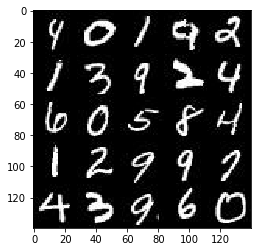

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

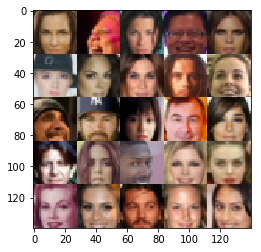

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def leaky_relu(tensor, alpha=0.01):
    return tf.maximum(tensor * alpha, tensor)

In [251]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Use a stride of two to reduce size.
        # Nothing special otherwise.
        conv1 = tf.layers.conv2d(images, 8, 3, 2, padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = leaky_relu(conv1)

        # Just another convolution layer. Increasing the filter count.
        conv2 = tf.layers.conv2d(conv1, 16, 3, 2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2)

        # A convolution layer without downsizing
        conv3 = tf.layers.conv2d(conv2, 32, 3, padding='same', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3)
        conv3 = tf.layers.dropout(conv3, 0.3, training=True)
        
        flattened = tf.contrib.layers.flatten(conv3)

        logits = tf.layers.dense(flattened, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [248]:
# adds batch normalization and leaky relu to a layer
def batch_normalize_and_activate(inputs, is_train):
    normalized = tf.layers.batch_normalization(inputs, training=is_train)
    with_activation = leaky_relu(normalized)
    
    return with_activation


def upsample_and_convolve(inputs, neighborhood_shape, filter_count, filter_shape, padding, is_train):
    resized = tf.image.resize_nearest_neighbor(inputs, neighborhood_shape)
    convolved = tf.layers.conv2d(resized, filter_count, filter_shape, padding=padding, activation=None)
    
    return batch_normalize_and_activate(convolved, is_train)

def transpose_convolve(inputs, filter_count, is_train, kernel_size=3, strides=2, padding='same', normalize=True):
    convolved = tf.layers.conv2d_transpose(inputs, filter_count, kernel_size, strides=strides, padding='same')
    
    if normalize:
        convolved = batch_normalize_and_activate(convolved, is_train)
    
    return convolved
    

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = (not is_train)):
        # add a fully-connected layer
        hidden_layer_size = 32 * 7 * 7
        h1 = tf.layers.dense(z, hidden_layer_size)
        h1 = batch_normalize_and_activate(h1, is_train)
        reshaped = tf.reshape(h1, [-1, 7, 7, hidden_layer_size // (7 * 7)])
        
        # high dropout with this early wide layer prevents overfitting
        reshaped = tf.layers.dropout(reshaped, 0.8, training=is_train)
        
        # A couple of straightforward transpose convolutions.
        # I have a high number of channels with high dropout to acheive an ensemble effect.
        up1 = transpose_convolve(reshaped, 1024, is_train)
        up1 = tf.layers.dropout(up1, 0.8, training=is_train)
        up2 = transpose_convolve(up1, 512, is_train)
        up2 = tf.layers.dropout(up2, 0.7, training=is_train)
        
        # the transpose convolutions tend to produce angular artifacts in the generated image.
        # using an upsample and convolution to replace one transpose convolution
        # improves the resulting images significantly.
        #up3 = transpose_convolve(up2, 128, is_train) #this is the skipped transpose convolution
        
        # Upsample instead of transpose convolve for a smoother output
        up3 = upsample_and_convolve(reshaped, (56,56), 64, (3,3), 'same', is_train)
        up3 = tf.layers.dropout(up3, 0.4, training=is_train)
        
        # we are now 2x too big, so use a down-convolution
        down = tf.layers.conv2d(up3, 32, (3, 3), strides=(2,2), padding='same', activation=None)
        down = batch_normalize_and_activate(down, is_train)
        
        # run a same-size convolution on the resulting output to sharpen it up
        same = tf.layers.conv2d(down, 16, 3, padding='same', activation=None)
        same = batch_normalize_and_activate(same, is_train)
        same = tf.layers.dropout(same, 0.1, training=is_train)
        
        # drop to the appropriate number of channels with a final convolution
        logits = tf.layers.conv2d(same, out_channel_dim, 1, padding='same', activation=None)
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/Maximum:0", shape=(?, 784), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [variable for variable in t_vars if variable.name.startswith('generator')]
    d_vars = [variable for variable in t_vars if variable.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [240]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # model definition
    _, image_width, image_height, image_channels = list(data_shape)
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_number = 0
            for batch_images in get_batches(batch_size):
                batch_number += 1
                
                #scale properly
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # the generator needs more training than the discriminator.
                # let it get there.
                train_iterations = 0
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                while g_loss.eval({input_z: batch_z, input_real: batch_images}) > train_loss_d and train_iterations < 5:
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                    train_iterations += 1
                
                # display sample images every 100 batches
                if batch_number % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                    # get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{} |".format(epoch_i + 1, epoch_count),
                          "Batch number {} |".format(batch_number),
                          "Discriminator Loss: {:.4f} |".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

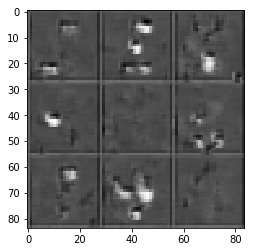

Epoch 1/2 | Batch number 100 | Discriminator Loss: 1.0788 | Generator Loss: 1.0896


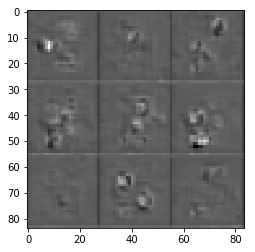

Epoch 1/2 | Batch number 200 | Discriminator Loss: 1.1435 | Generator Loss: 1.3002


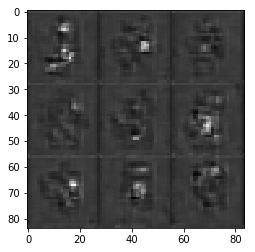

Epoch 1/2 | Batch number 300 | Discriminator Loss: 1.1566 | Generator Loss: 0.9681


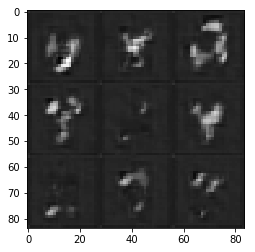

Epoch 1/2 | Batch number 400 | Discriminator Loss: 1.1508 | Generator Loss: 1.1740


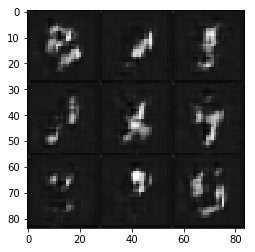

Epoch 1/2 | Batch number 500 | Discriminator Loss: 1.1094 | Generator Loss: 1.2845


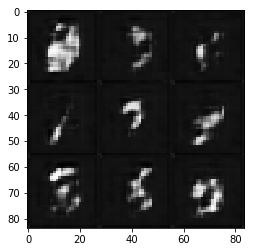

Epoch 1/2 | Batch number 600 | Discriminator Loss: 1.1831 | Generator Loss: 1.2124


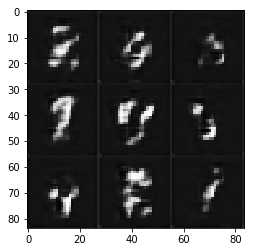

Epoch 1/2 | Batch number 700 | Discriminator Loss: 1.1515 | Generator Loss: 1.1420


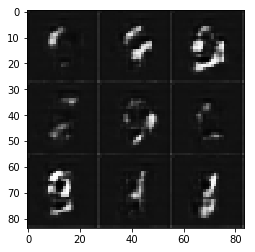

Epoch 1/2 | Batch number 800 | Discriminator Loss: 1.2155 | Generator Loss: 1.0325


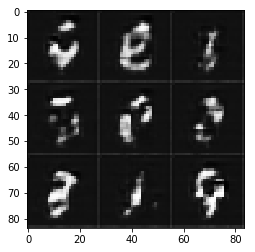

Epoch 1/2 | Batch number 900 | Discriminator Loss: 1.1365 | Generator Loss: 1.1316


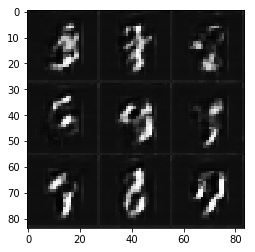

Epoch 2/2 | Batch number 100 | Discriminator Loss: 1.1500 | Generator Loss: 1.2116


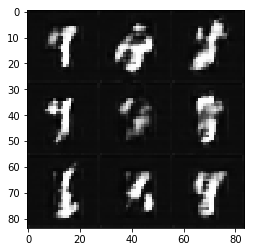

Epoch 2/2 | Batch number 200 | Discriminator Loss: 1.1505 | Generator Loss: 1.0429


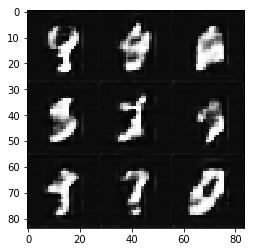

Epoch 2/2 | Batch number 300 | Discriminator Loss: 1.1267 | Generator Loss: 1.0075


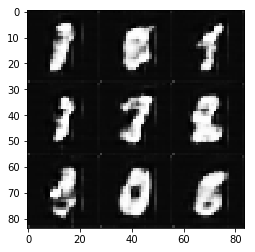

Epoch 2/2 | Batch number 400 | Discriminator Loss: 1.2988 | Generator Loss: 1.0812


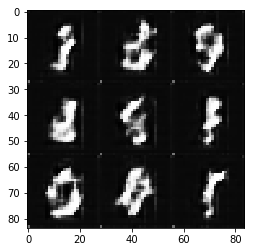

Epoch 2/2 | Batch number 500 | Discriminator Loss: 1.1494 | Generator Loss: 1.0802


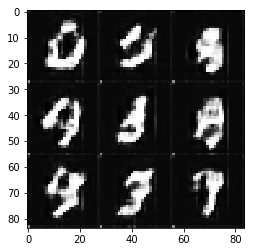

Epoch 2/2 | Batch number 600 | Discriminator Loss: 1.1239 | Generator Loss: 1.2168


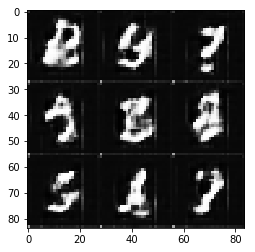

Epoch 2/2 | Batch number 700 | Discriminator Loss: 1.2715 | Generator Loss: 1.1344


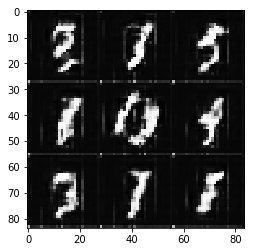

Epoch 2/2 | Batch number 800 | Discriminator Loss: 1.2122 | Generator Loss: 1.0243


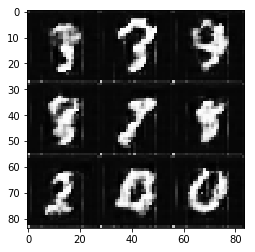

Epoch 2/2 | Batch number 900 | Discriminator Loss: 1.2106 | Generator Loss: 1.0795


In [232]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

# might need to run this more than once :)
tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

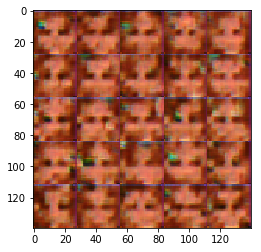

Epoch 1/1 | Batch number 100 | Discriminator Loss: 0.6134 | Generator Loss: 2.1594


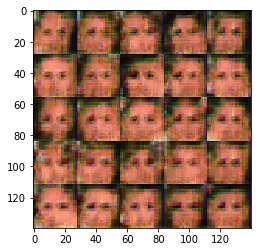

Epoch 1/1 | Batch number 200 | Discriminator Loss: 0.7122 | Generator Loss: 1.8936


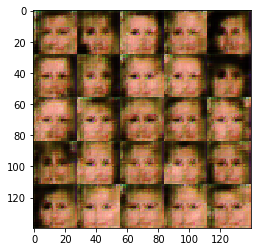

Epoch 1/1 | Batch number 300 | Discriminator Loss: 0.7691 | Generator Loss: 2.0935


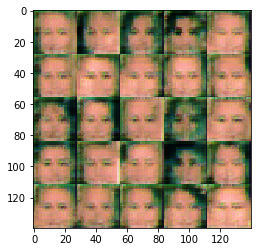

Epoch 1/1 | Batch number 400 | Discriminator Loss: 0.9938 | Generator Loss: 1.2377


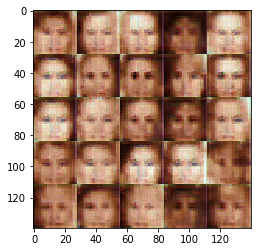

Epoch 1/1 | Batch number 500 | Discriminator Loss: 0.9161 | Generator Loss: 2.6934


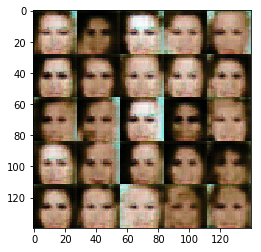

Epoch 1/1 | Batch number 600 | Discriminator Loss: 0.8312 | Generator Loss: 2.1292


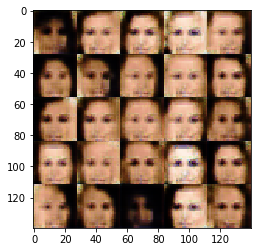

Epoch 1/1 | Batch number 700 | Discriminator Loss: 0.7925 | Generator Loss: 2.1942


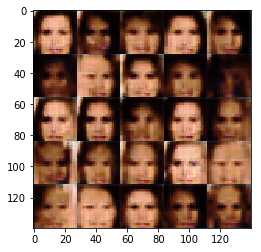

Epoch 1/1 | Batch number 800 | Discriminator Loss: 1.0168 | Generator Loss: 2.8641


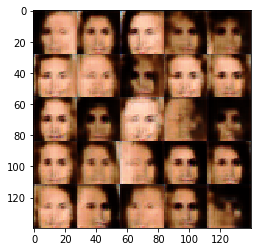

Epoch 1/1 | Batch number 900 | Discriminator Loss: 1.0533 | Generator Loss: 0.9910


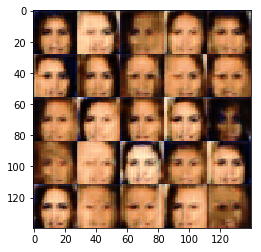

Epoch 1/1 | Batch number 1000 | Discriminator Loss: 0.7382 | Generator Loss: 2.2787


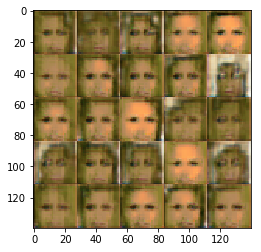

Epoch 1/1 | Batch number 1100 | Discriminator Loss: 0.5718 | Generator Loss: 2.5140


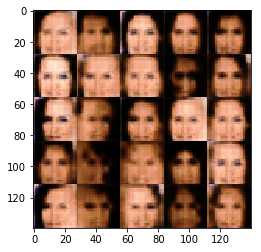

Epoch 1/1 | Batch number 1200 | Discriminator Loss: 0.7429 | Generator Loss: 1.7031


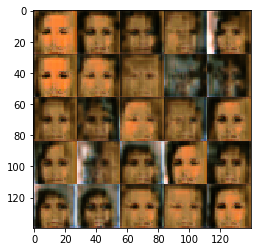

Epoch 1/1 | Batch number 1300 | Discriminator Loss: 0.4961 | Generator Loss: 2.7374


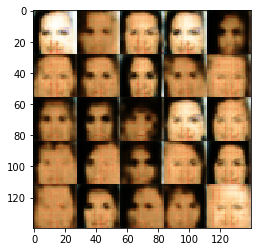

Epoch 1/1 | Batch number 1400 | Discriminator Loss: 0.9259 | Generator Loss: 1.3040


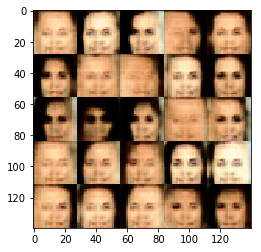

Epoch 1/1 | Batch number 1500 | Discriminator Loss: 0.6838 | Generator Loss: 2.1388


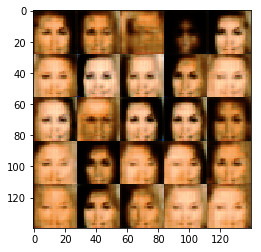

Epoch 1/1 | Batch number 1600 | Discriminator Loss: 1.1842 | Generator Loss: 1.0895


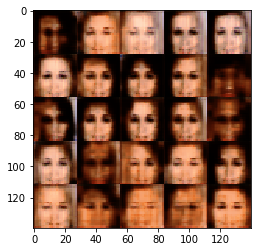

Epoch 1/1 | Batch number 1700 | Discriminator Loss: 0.7629 | Generator Loss: 3.2147


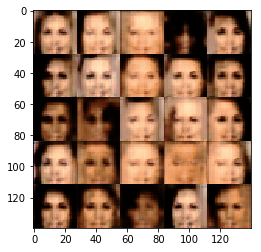

Epoch 1/1 | Batch number 1800 | Discriminator Loss: 0.7552 | Generator Loss: 3.2653


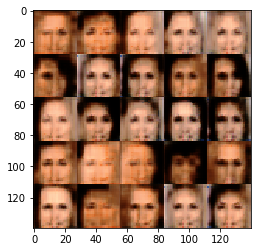

Epoch 1/1 | Batch number 1900 | Discriminator Loss: 0.5654 | Generator Loss: 3.4152


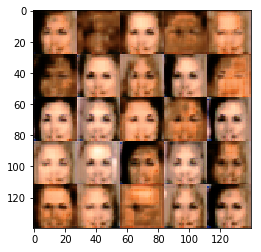

Epoch 1/1 | Batch number 2000 | Discriminator Loss: 0.9750 | Generator Loss: 1.6038


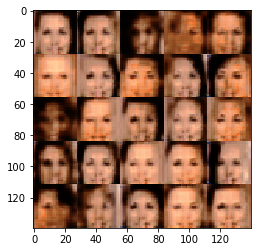

Epoch 1/1 | Batch number 2100 | Discriminator Loss: 0.5616 | Generator Loss: 3.5480


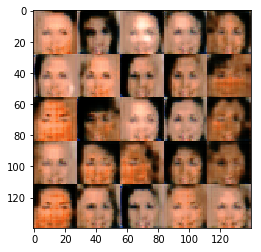

Epoch 1/1 | Batch number 2200 | Discriminator Loss: 0.6175 | Generator Loss: 2.8531


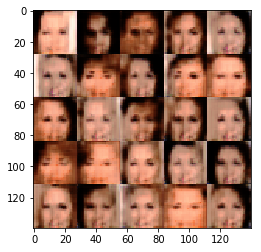

Epoch 1/1 | Batch number 2300 | Discriminator Loss: 0.5613 | Generator Loss: 2.6063


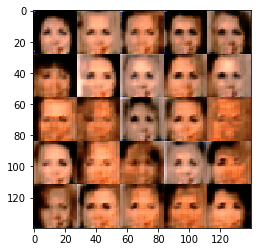

Epoch 1/1 | Batch number 2400 | Discriminator Loss: 0.7046 | Generator Loss: 2.3459


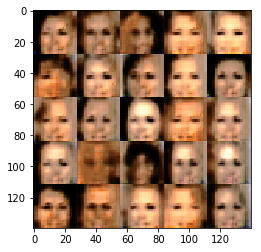

Epoch 1/1 | Batch number 2500 | Discriminator Loss: 0.5391 | Generator Loss: 3.2112


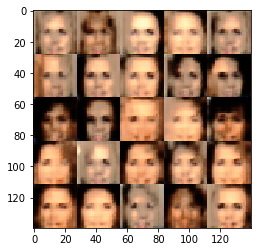

Epoch 1/1 | Batch number 2600 | Discriminator Loss: 0.4611 | Generator Loss: 3.9591


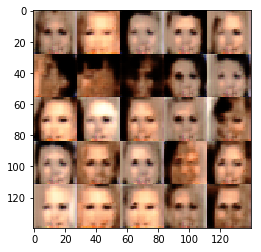

Epoch 1/1 | Batch number 2700 | Discriminator Loss: 0.5414 | Generator Loss: 2.7697


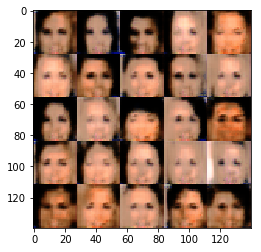

Epoch 1/1 | Batch number 2800 | Discriminator Loss: 0.4655 | Generator Loss: 3.4023


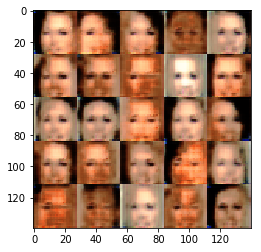

Epoch 1/1 | Batch number 2900 | Discriminator Loss: 0.4572 | Generator Loss: 3.8195


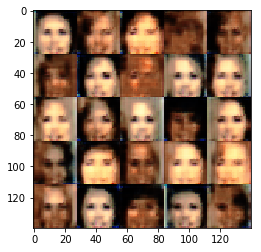

Epoch 1/1 | Batch number 3000 | Discriminator Loss: 0.4823 | Generator Loss: 3.6515


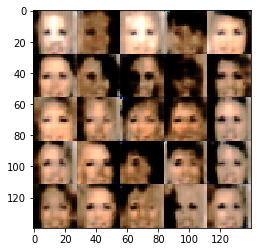

Epoch 1/1 | Batch number 3100 | Discriminator Loss: 0.4700 | Generator Loss: 3.7742


In [254]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

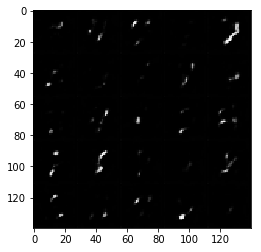

Epoch 1/2 | Batch number 100 | Discriminator Loss: 0.8867 | Generator Loss: 1.6849


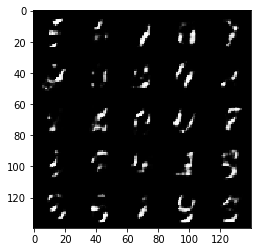

Epoch 1/2 | Batch number 200 | Discriminator Loss: 0.8628 | Generator Loss: 1.8046


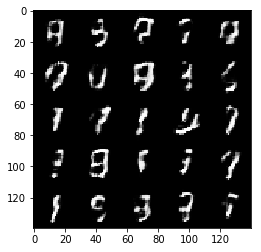

Epoch 1/2 | Batch number 300 | Discriminator Loss: 0.8013 | Generator Loss: 1.6745


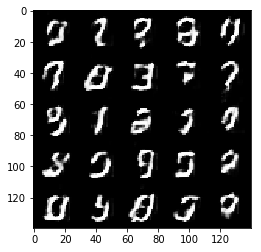

Epoch 1/2 | Batch number 400 | Discriminator Loss: 0.9694 | Generator Loss: 1.3375


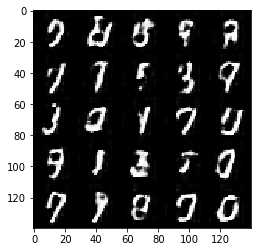

Epoch 1/2 | Batch number 500 | Discriminator Loss: 0.9928 | Generator Loss: 1.0513


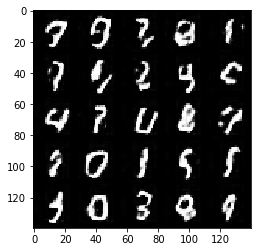

Epoch 1/2 | Batch number 600 | Discriminator Loss: 0.8781 | Generator Loss: 2.5764


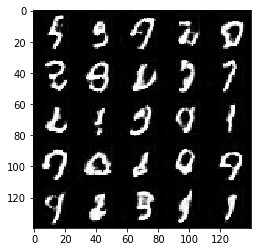

Epoch 1/2 | Batch number 700 | Discriminator Loss: 0.9674 | Generator Loss: 1.1092


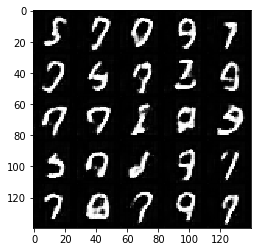

Epoch 1/2 | Batch number 800 | Discriminator Loss: 0.7446 | Generator Loss: 2.3904


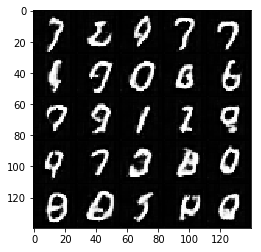

Epoch 1/2 | Batch number 900 | Discriminator Loss: 0.8557 | Generator Loss: 2.3252


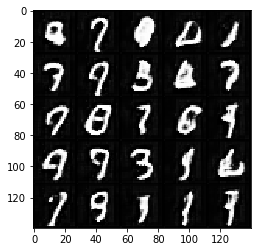

Epoch 2/2 | Batch number 100 | Discriminator Loss: 0.8386 | Generator Loss: 2.3353


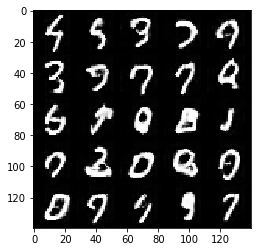

Epoch 2/2 | Batch number 200 | Discriminator Loss: 1.0640 | Generator Loss: 1.1896


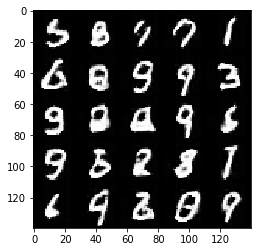

Epoch 2/2 | Batch number 300 | Discriminator Loss: 0.7423 | Generator Loss: 2.4439


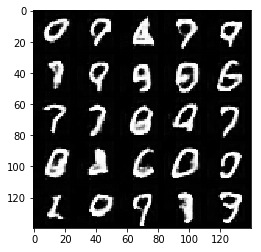

Epoch 2/2 | Batch number 400 | Discriminator Loss: 0.8048 | Generator Loss: 2.5300


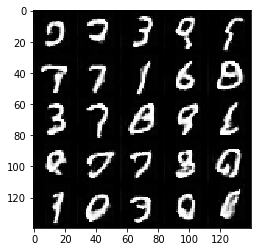

Epoch 2/2 | Batch number 500 | Discriminator Loss: 0.8321 | Generator Loss: 1.7274


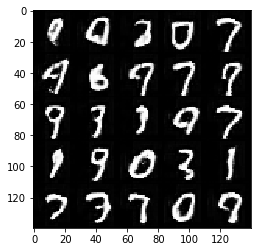

Epoch 2/2 | Batch number 600 | Discriminator Loss: 0.8783 | Generator Loss: 1.8248


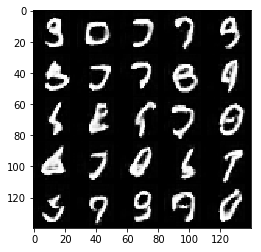

Epoch 2/2 | Batch number 700 | Discriminator Loss: 0.7533 | Generator Loss: 2.4775


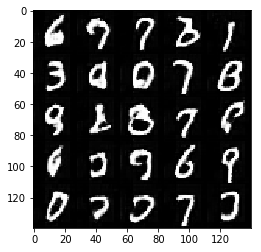

Epoch 2/2 | Batch number 800 | Discriminator Loss: 0.7472 | Generator Loss: 2.3794


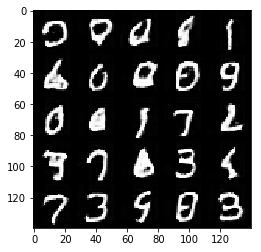

Epoch 2/2 | Batch number 900 | Discriminator Loss: 0.7747 | Generator Loss: 1.9321


In [255]:
# I ran the MNIST tests above with a weakened discriminator to meet the requirement that the
# generator loss be lower than the discriminator loss. With my heavy usage of dropout,
# that requirement forced me to have a less-good discriminator.
# These tests are run with a better one, mostly for fun.

batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

# might need to run this more than once :)
tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.